In [1]:
%matplotlib inline
import os
import multiprocessing

import scipy
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as CV

from pymatgen.io.vasp import Poscar
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view
from sklearn.svm import SVR

Requirements:
numpy, scipy, pandas, pymatgen, sklearn, ase


Optional: tqdm for progress bars, thundersvm for GPU support

In [2]:
#from thundersvm import SVR # much faster with GPU support

def tw(iterable, **kwargs):
    "Add a progress bar using tqdm if available"
    try:
        import tqdm
        tqdm.tqdm._instances.clear()
        # clear existing instances
    except AttributeError:
        pass
    try:
        return tqdm.tqdm_notebook(iterable, **kwargs)
    except NameError:
        return iterable  # could not import tqdm

# Set up (basic settings here)

CdTe dataset is available at /ufrc/hennig/sxiexie/CdTe_Archive


Big picture:
1) Parse structure and energy files

2) Generate representations

3) Optimize and fit models with support vector regression

In [3]:
n_cores = 1  # number of cores to use for multiprocessing.

In [4]:
### uncomment the following line to use all available cores
n_cores = multiprocessing.cpu_count()

In [5]:
# directory of POSCARs and energy files
working_directory = '/home/jason/Downloads'
directory_path = working_directory + "/CdTe_Archive/"

structure_ext = 'poscar'  #file extension names
target_ext = 'energy'

element_list = ['Cd', 'Te']  # list of elements to consider

# File Parsing

In [7]:
def process_entry(args):
    """parse files"""
    entry_name, element_list, directory_path, structure_ext, target_ext = args
    target_file = '{}/{}.{}'.format(directory_path,
                                    entry_name,
                                    target_ext)
    with open(target_file) as f:
        lines = f.read().splitlines()
    local_energies = [float(line) for line in lines]
    # This dataset has per-atom energies but we won't use them
    energy = np.sum(local_energies)
    
    structure_file = '{}/{}.{}'.format(directory_path,
                                       entry_name,
                                       structure_ext)
    structure = Poscar.from_file(structure_file).structure
    entry_data = [len(structure), energy]
    for element in element_list:
        element_percent = structure.composition.get_atomic_fraction(element)
        entry_data.append(element_percent)
    return structure, entry_data

file_stems = [os.path.splitext(f)[0]
              for f in os.listdir(directory_path) 
              if structure_ext in f]
# check the working directory for files matching the ext

columns = ['Size', 'Total Energy'] + element_list  # pandas header

# prepare zipped arguments for parallel parsing
zipped_args = [(f, element_list, directory_path, structure_ext, target_ext)
               for f in file_stems]
parsed_data = list(tw(multiprocessing.Pool(n_cores).imap(process_entry,
                                                         zipped_args),
                      total=len(zipped_args)))

/home/jason/.virtualenvs/trydjango/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [8]:
# unpack parallel parsing results
structure_list, table_data = zip(*parsed_data)
structures = {k: v for k, v in zip(file_stems, structure_list)}
df = pd.DataFrame(columns=columns, data=table_data, index=file_stems)

# Get Reference Energies

While learning on total energies is desirable in some scenarios, we often want to predict formation energy per atom to compare relative stabilities. Here, we normalize the total energy of each structure by the reference energies. These are the lowest-energy elemental structures in the dataset.

In [9]:
reference_energies = {}
for element in element_list:
    pure_entries = df[df[element] == 1.0]
    pure_entry_energies = pure_entries['Total Energy'].values
    pure_entry_energies /= pure_entries['Size'].values
    minimum_energy = np.min(pure_entry_energies)
    reference_energies[element] = minimum_energy

In [10]:
reference_energies

{'Cd': -1.16003, 'Te': -2.23009}

# Compute Formation Energies

In [11]:
def get_formation_energy(entry_data, element_list, reference_energies):
    element_fractions = {element: entry_data[element] 
                         for element in element_list}
    reference_contributions = [(reference_energies[element] 
                               * element_fractions[element])
                               for element in element_list]
    formation_energy = (entry_data['Total Energy']/entry_data['Size'] 
                        - np.sum(reference_contributions))
    return formation_energy

In [12]:
df['Formation Energy'] = df.apply(get_formation_energy, axis=1, 
                                  args=(element_list, reference_energies))

# Set up DSCRIBE's SOAP Handler

The Smooth Overlap of Atomic Positions representation is a well-established method for capturing atomic environments for machine learning. It has few hyperparameters, and the default choices here are reasonable for many systems.

In [79]:
from dscribe.descriptors import SOAP
rcut = 7  # maximum pairwise distance to consider. 
# Stick to the second or third nearest-neighbor distance.

# maximum degree and orders to calculation in spherical harmonics power-series solution
nmax = 8
lmax = 8

# Setting up the SOAP descriptor
soap = SOAP(species=element_list,
            periodic=True,
            rcut=rcut,
            nmax=nmax,
            lmax=lmax,
            rbf='gto',
            sigma=0.125,
            average=True)

In [80]:
adaptor = AseAtomsAdaptor()
entry_names = sorted(structures.keys())
flattened_entry_list = [adaptor.get_atoms(structures[entry_name])
                        for entry_name in entry_names]
soap_raw = soap.create(flattened_entry_list, n_jobs=n_cores)

In [81]:
data = pd.DataFrame(data=soap_raw, index=entry_names,
                    columns=['SOAP_{}'.format(i) for i in range(len(soap_raw[0]))])

Each entry has its own 567-dimensional vector representing the chemical environment.

# Visualizing SOAP

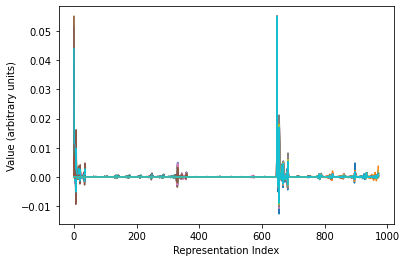

In [82]:
import matplotlib.pyplot as plt
for i in range(50):
    plt.plot(np.arange(len(soap_raw[0])), data.iloc[i])
plt.xlabel('Representation Index')
plt.ylabel('Value (arbitrary units)')
plt.show()

# Data Splitting

In [83]:
shuffled_names = list(entry_names)
np.random.shuffle(shuffled_names)

In [84]:
training_fraction = 0.8
n_train = int(len(df) * training_fraction)

training_names = shuffled_names[:n_train]
testing_names = shuffled_names[n_train:]

In [85]:
training_inputs = data.loc[training_names].values
print(training_inputs.shape)
training_outputs = df.loc[training_names]['Formation Energy']
print(training_outputs.shape)

(3738, 972)
(3738,)


In [86]:
testing_inputs = data.loc[testing_names].values
print(testing_inputs.shape)
testing_outputs = df.loc[testing_names]['Formation Energy']
print(testing_outputs.shape)

(935, 972)
(935,)


In [72]:
from api.rest import QueryEngine as q

model=q.get_KRR('CdTe')

http://10.5.46.39/static/models/CdTe.sav


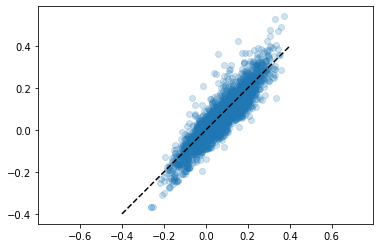

In [73]:
testing_predictions = model.predict(training_inputs)
plt.scatter(testing_predictions, training_outputs, alpha=0.2)
plt.plot([-0.4, 0.4], [-0.4, 0.4], 'k--')
plt.axis('equal')
plt.show()

In [ ]:
print(testing_predictions)

# Let's do ML

In [87]:
model = SVR().fit(training_inputs, training_outputs)

In [88]:
testing_predictions = model.predict(testing_inputs)

In [89]:
print(np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))


0.043313774181390464


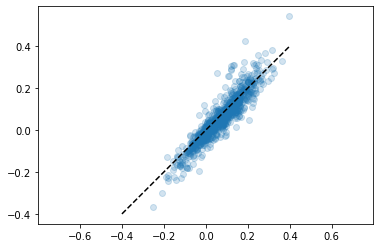

In [90]:
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-0.4, 0.4], [-0.4, 0.4], 'k--')
plt.axis('equal')
plt.show()

# Normalizing Representations

Often, it is helpful to normalize the inputs for machine learning. Earlier, we observed that the ranges across different features in the representation can vary dramatically. Here, we normalize all 576 features independently such that they are centered at 0 and have a variance of 1. This is not always necessary, depending on the representation chosen. It does not appear to help with SOAP.

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(training_inputs)
training_inputs = scaler.transform(training_inputs)
testing_inputs = scaler.transform(testing_inputs)

<function matplotlib.pyplot.show(*args, **kw)>

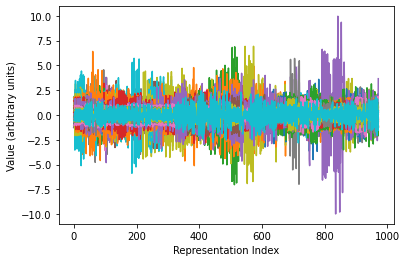

In [93]:
import matplotlib.pyplot as plt
for i in range(50):
    plt.plot(np.arange(len(soap_raw[0])), training_inputs[i])
plt.xlabel('Representation Index')
plt.ylabel('Value (arbitrary units)')
plt.show

In [94]:
model = SVR().fit(training_inputs, training_outputs)

In [95]:
testing_predictions = model.predict(testing_inputs)

In [96]:
print(np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))

0.05972275220457412


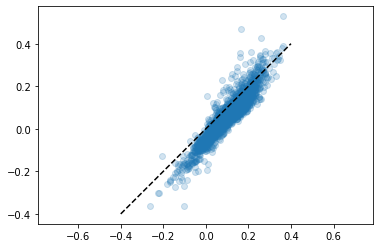

In [31]:
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-0.4, 0.4], [-0.4, 0.4], 'k--')
plt.axis('equal')
plt.show()

In [91]:
import pickle
pickle.dump(model,open('Cd-Te.sav','wb'))

# Random search to select best hyperparameters

Almost every machine learning algorithm is associated with hyperparameters -- parameters that are not optimized by the algorithm itself, like weights. Examples include the choice of and options associated with representations, depth of the neural network, and regularization strength in various solvers. Here, we optimize Gamma and C, which are hyperparameters of support vector regression.

The C parameter trades off misclassification of training examples against simplicity of the model.

Gamma defines an overall scale factor for the support vector machine's notion of distance between two points.

In [65]:
cScale = 5  # scale for exponential distribution
gScale = 0.001  # scale for exponential distribution
n_iter = 5  # number of iterations for random search. Realistically ~100
    
param_dist = {'C': scipy.stats.expon(scale=cScale), 
              'gamma': scipy.stats.expon(scale=gScale), 
              'kernel': ['rbf']}

# using random search cross validation to select best hyperparameters,
# performing 5-fold cross validation
cv = CV(SVR(), 
        param_distributions=param_dist, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_iter=n_iter, 
        n_jobs=n_cores, 
        refit=False) 

search=cv.fit(training_inputs, training_outputs) #trains the model using training set alone

C = search.best_params_['C']
gamma = search.best_params_['gamma']
print(search.best_params_)

{'C': 1.1860525310410928, 'gamma': 0.003780151108509245, 'kernel': 'rbf'}


In [66]:
model = SVR(C=C, gamma=gamma)
model.fit(training_inputs, training_outputs)
testing_predictions = model.predict(testing_inputs)

In [67]:
print(np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))

0.11062657545383316


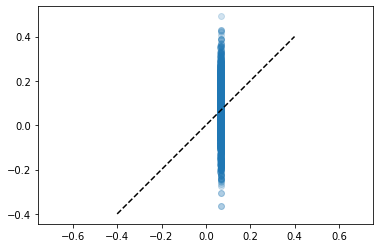

In [68]:
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-0.4, 0.4], [-0.4, 0.4], 'k--')
plt.axis('equal')
plt.show()

In [61]:
import pickle
pickle.dump(model,open('Cd-Te.sav','wb'))

In [ ]:
clf = pickle.load(open('CdTe.sav','rb'))
testing_predictions = clf.predict(testing_inputs)
print(np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-0.4, 0.4], [-0.4, 0.4], 'k--')
plt.axis('equal')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import nglview as nv
import pytraj as pt

p_traj = pt.load(nv.datafiles.TRR, top=nv.datafiles.PDB)
p_view = nv.show_pytraj(p_traj)
p_view._display_image()

Even with as few as 5 random iterations, we see a huge effect on performance.